# Stock Price Forecasting

This project explores machine learning techniques to predict stock price movements based on historical data. It includes data preprocessing, feature engineering model training, evaluation, and visualization of results. The goal is to analyze patterns in stock prices and build predictive models that can provide useful insights for financial forecasting.

---

**Models:**
- ARIMA (Statistical Model)
- XGBoost (ML Model)
- LSTM (Deep Learning Model)

---

**Author:** Md. Tushar Shihab<br>
**Objective:** Predict next-day closing price using optimized models

# Imports Libraries & Configuration

In [1]:

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Core Python libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Scikit-learn utilities for evaluation and preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

# Machine Learning models and optimization
import xgboost as xgb
import optuna

# ARIMA models for time series forecasting
from pmdarima import auto_arima
from pmdarima.arima import ARIMA as PmdARIMA

# Deep Learning with Keras (LSTM for sequential data like stock prices)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Utility imports
import datetime
import os

# Reproducibility setup
np.random.seed(42)
tf.random.set_seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

from pathlib import Path

# Load and Prepare Data

In [2]:
# The stock we'll use for this analysis
stock = 'AAPL'

# data range for stock data
start = '2012-01-01'
end = '2024-12-31'

# Download stock data using yfinance
data = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
# display data
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.345174,12.383300,12.278229,12.290238,302220800
2012-01-04,12.411519,12.448745,12.286636,12.308250,260022000
2012-01-05,12.549306,12.564916,12.388398,12.456844,271269600
2012-01-06,12.680502,12.691009,12.585038,12.601549,318292800
2012-01-09,12.660382,12.841103,12.648974,12.773559,394024400


In [4]:
# shape of the dataset
data.shape

(3269, 5)

## Standardize Dataset

In [5]:
# reset index to make Date a column
data.reset_index(inplace=True)

In [6]:
# flatten the column names (remove multi-level, unnecessary tags)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [''.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

In [7]:
data.columns

Index(['Date', 'CloseAAPL', 'HighAAPL', 'LowAAPL', 'OpenAAPL', 'VolumeAAPL'], dtype='object')

In [8]:
# rename columns to clean names
data.rename(columns={
    'CloseAAPL': 'Close',
    'HighAAPL': 'High',
    'LowAAPL': 'Low',
    'OpenAAPL': 'Open',
    'VolumeAAPL': 'Volume'
}, inplace=True)

In [9]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2012-01-03,12.345174,12.383300,12.278229,12.290238,302220800
1,2012-01-04,12.411519,12.448745,12.286636,12.308250,260022000
2,2012-01-05,12.549306,12.564916,12.388398,12.456844,271269600
3,2012-01-06,12.680502,12.691009,12.585038,12.601549,318292800
4,2012-01-09,12.660382,12.841103,12.648974,12.773559,394024400


In [10]:
# fix date columns if there is any inconsistent or unusual dates
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

## Understand the dataset

In [11]:
# descriptive statistics about the Data
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,3269,2018-07-01 23:14:37.699602432,2012-01-03 00:00:00,2015-04-06 00:00:00,2018-07-02 00:00:00,2021-09-29 00:00:00,2024-12-30 00:00:00,NaN
Close,3269.0,76.242169,11.8968,23.223892,41.571022,139.147583,258.103729,65.849788
High,3269.0,76.981344,12.173102,23.351528,41.837849,140.838071,259.179926,66.457532
Low,3269.0,75.423667,11.731384,23.031585,41.176442,136.593817,256.718662,65.147895
Open,3269.0,76.176454,11.818814,23.199499,41.550747,139.084476,257.276679,65.767061
Volume,3269.0,181275898.348119,23234700.0,79592600.0,121517600.0,216229200.0,1506120000.0,166798882.858728


In [12]:
# information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3269 entries, 0 to 3268
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3269 non-null   datetime64[ns]
 1   Close   3269 non-null   float64       
 2   High    3269 non-null   float64       
 3   Low     3269 non-null   float64       
 4   Open    3269 non-null   float64       
 5   Volume  3269 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 153.4 KB


# Analytical Plots

## Closing Price

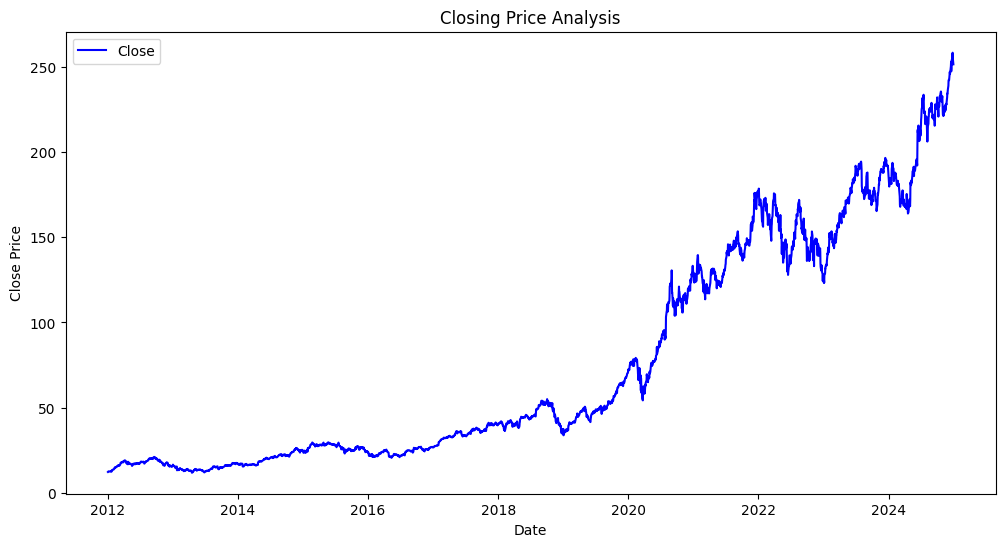

In [13]:
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.title(f"Closing Price Analysis")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

## Volume of Sales

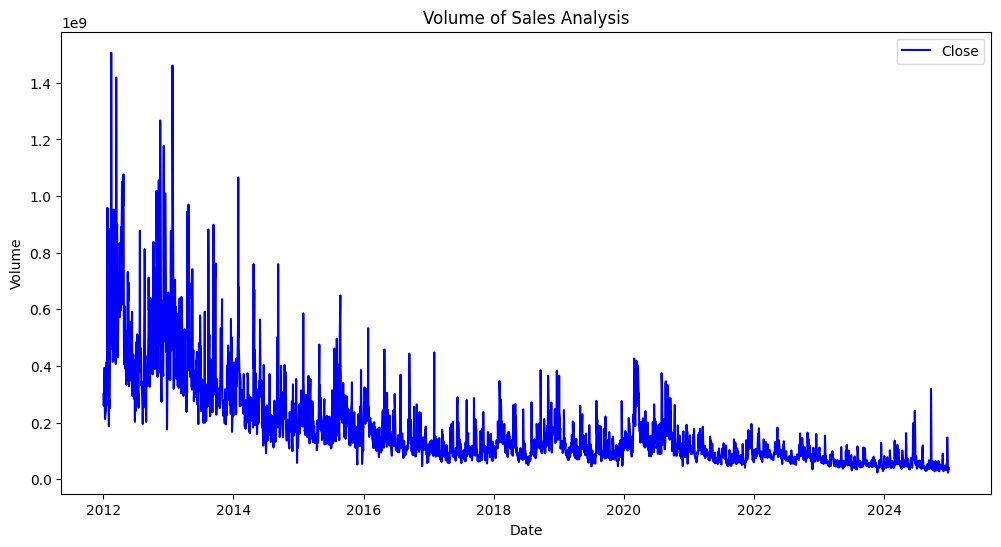

In [14]:
plt.figure(figsize=(12, 6))

# Plot the closing price
plt.plot(data['Date'], data['Volume'], label='Close', color='blue')
plt.title(f"Volume of Sales Analysis")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()

# Moving Average of the Stock

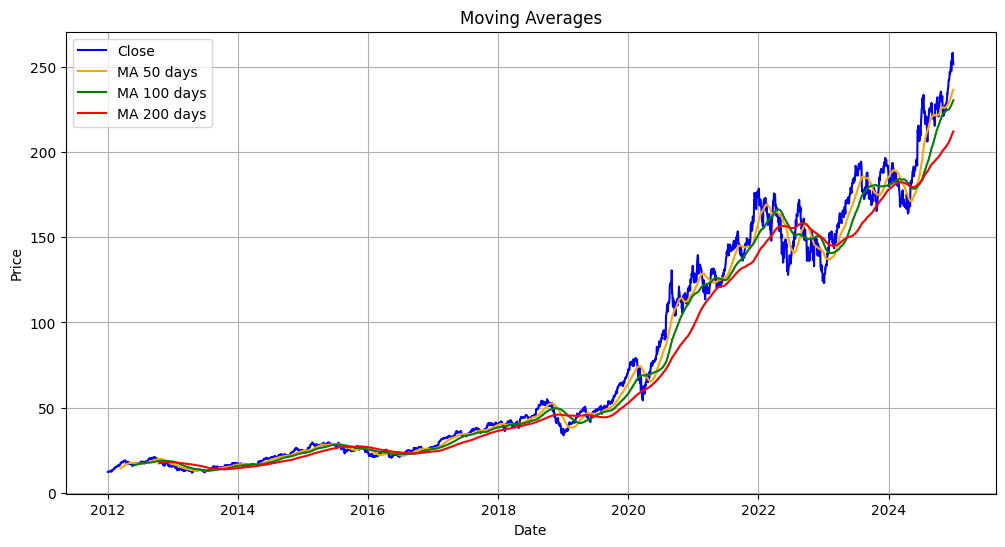

In [15]:
# define moving averages
ma_days = [50, 100, 200]
ma_colors = ['orange', 'green', 'red']

# calculate moving averages
for ma in ma_days:
    column_name = f"MA_{ma}"
    data[column_name] = data['Close'].rolling(ma).mean()

# plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close', color='blue')

# plot each moving average
for ma, color in zip(ma_days, ma_colors):
    plt.plot(data['Date'], data[f"MA_{ma}"], label=f"MA {ma} days", color=color)

plt.title(f"Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# Daily return of the stock on average

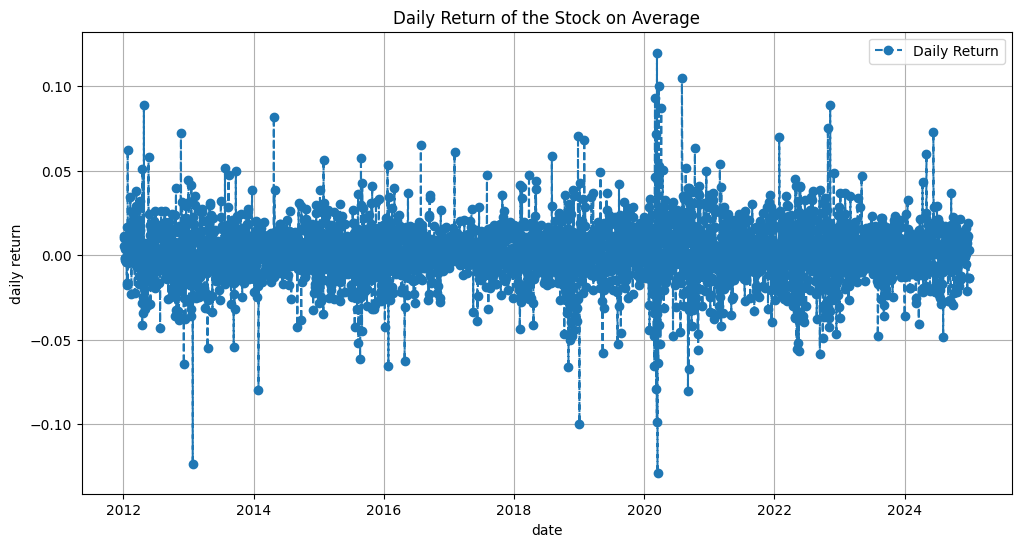

In [16]:
# calculate daily return
data['DailyReturn'] = data['Close'].pct_change()

# plot daily return percentage
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['DailyReturn'], linestyle='--', marker='o', label='Daily Return')

plt.title(f"Daily Return of the Stock on Average")
plt.xlabel("date")
plt.ylabel("daily return")
plt.legend()
plt.grid(True)
plt.show()


## Persist dataset

In [17]:
output_dir = file = Path(r"../data")
output_dir.mkdir(parents=True, exist_ok=True)           # create folder if it doesn't exist

# define file path
file_path = output_dir / f"{stock}_preprocessed.csv"

# save dataframe to csv
data.to_csv(file_path, index=False)


# Model Development

In [18]:
# function to split data into train, validation, and test sets by date
def time_based_split(df):
    """Split data into train, validation, and test sets by index proportion."""
    train_end = int(len(df) * 0.8)
    val_end = int(len(df) * 0.9)

    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    
    print("Data Split Summary:")
    print(f"Train:  {train.index.min()} → {train.index.max()}  ({len(train)} rows)")
    print(f"Val:    {val.index.min()} → {val.index.max()}    ({len(val)} rows)")
    print(f"Test:   {test.index.min()} → {test.index.max()}   ({len(test)} rows)")
    

    return train, val, test

In [19]:
# time-based split by proportion
train, val, test = time_based_split(data)

Data Split Summary:
Train:  0 → 2614  (2615 rows)
Val:    2615 → 2941    (327 rows)
Test:   2942 → 3268   (327 rows)


## Helper Functions

In [20]:
# Evaluation Metrics
def calculate_metrics(y_true, y_pred, prefix=""):
    # calculate regression metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        f"{prefix}MSE": mse,
        f"{prefix}MAE": mae,
        f"{prefix}RMSE": rmse,
        f"{prefix}R2": r2,
        f"{prefix}MAPE": mape
    }

In [ ]:
# create Lagged Features (for ML/DL)
def create_lagged_features(series, lags=10):
    # create lagged features for supervised learning.
    data = pd.DataFrame(series, columns=['Close'])
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].shift(lag)
    data.dropna(inplace=True)
    return data

In [22]:
# Prepare ML data once
def prepare_ml_data(y_train, y_val, y_test, lags=10):
    y_full_train = np.concatenate([y_train, y_val])
    y_full_all = np.concatenate([y_full_train, y_test])
    df_all = create_lagged_features(y_full_all, lags)
    n_train = len(y_train) - lags
    n_val = len(y_val)
    n_test = len(y_test)
    X_train = df_all.iloc[:n_train, 1:].values
    y_train_ml = df_all.iloc[:n_train, 0].values
    X_val = df_all.iloc[n_train:n_train + n_val, 1:].values
    y_val_ml = df_all.iloc[n_train:n_train + n_val, 0].values
    X_test = df_all.iloc[n_train + n_val:n_train + n_val + n_test, 1:].values
    y_test_ml = df_all.iloc[n_train + n_val:n_train + n_val + n_test, 0].values
    return X_train, y_train_ml, X_val, y_val_ml, X_test, y_test_ml

In [23]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [ ]:
# Prints a single table showing both train and test performance for a model.
def print_evaluation_tables(model_name, train_metrics, test_metrics):
    # Create a DataFrame with Train and Test as columns
    perf = pd.DataFrame({
        'Train': train_metrics,
        'Test': test_metrics
    })
    
    print(f"--- Performance Comparison: Train vs Test ({model_name}) ---")
    return perf.round(3)

## Feature Selection & Model Configuration

In [25]:
# extract target series
y_train = train['Close'].values
y_val = val['Close'].values
y_test = test['Close'].values

In [26]:
# set lags
LAGS = 10
SEQ_LEN = 10  # For LSTM

# train-test split for ml model
x_train, y_train_ml, x_val, y_val_ml, X_test, y_test_ml = prepare_ml_data(y_train, y_val, y_test, LAGS)

In [27]:
# Prepare LSTM data
scaler = MinMaxScaler()
y_full_scaled = scaler.fit_transform(data[['Close']]).flatten()
train_end_idx = len(train)
val_end_idx = train_end_idx + len(val)
y_train_scaled = y_full_scaled[:train_end_idx]
y_val_scaled = y_full_scaled[train_end_idx:val_end_idx]
y_test_scaled = y_full_scaled[val_end_idx:]

In [28]:
# create sequence
X_train_seq, y_train_seq = create_sequences(y_train_scaled, SEQ_LEN)
X_val_seq, y_val_seq = create_sequences(y_val_scaled, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(y_test_scaled, SEQ_LEN)
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_val_seq = X_val_seq.reshape((X_val_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_train_seq.shape[1], 1))

In [29]:
# dictionary for comparing models
final_test_metrics = {}

# Statistical Model: ARIMA

## Baseline Modeling

In [30]:
""" Baseline ARIMA (Default Parameters) """

try:
    arima_baseline = PmdARIMA(order=(1, 1, 1))
    arima_baseline.fit(y_train)
    arima_base_train_pred = arima_baseline.predict_in_sample()
    arima_base_test_pred = arima_baseline.predict(n_periods=len(y_test))
except Exception as e:
    print(f"Baseline failed, using naive forecast: {e}")
    arima_base_train_pred = np.full_like(y_train, y_train[-1])
    arima_base_test_pred = np.full_like(y_test, y_train[-1])

arima_base_train_metrics = calculate_metrics(y_train[-len(arima_base_train_pred):], arima_base_train_pred)
arima_base_test_metrics = calculate_metrics(y_test, arima_base_test_pred)

In [31]:
# Performance of ARIMA Baseline
print_evaluation_tables("ARIMA Baseline", arima_base_train_metrics, arima_base_test_metrics)

--- Performance Comparison: Train vs Test (ARIMA Baseline) ---
      Train      Test
MSE   1.772  3138.620
MAE   0.694    51.857
RMSE  1.331    56.023
R2    0.999    -4.014
MAPE  1.297    25.012


## Optimized Optimized Modeling

In [32]:
arima_opt = auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=5, max_d=2, max_q=5)
arima_opt_train_pred = arima_opt.predict_in_sample()
arima_opt_test_pred = arima_opt.predict(n_periods=len(y_test))

arima_opt_train_metrics = calculate_metrics(y_train[-len(arima_opt_train_pred):], arima_opt_train_pred)
arima_opt_test_metrics = calculate_metrics(y_test, arima_opt_test_pred)

In [33]:
print_evaluation_tables("ARIMA Optimized", arima_opt_train_metrics, arima_opt_test_metrics)

--- Performance Comparison: Train vs Test (ARIMA Optimized) ---
      Train      Test
MSE   1.772  3131.275
MAE   0.694    51.787
RMSE  1.331    55.958
R2    0.999    -4.002
MAPE  1.297    24.977


## Performance Summary of ARIMA Before and After Optimization

In [ ]:
print("Performance Summary for ARIMA Models")
arima_summary = pd.DataFrame({
    'Baseline_Train': arima_base_train_metrics,
    'Baseline_Test': arima_base_test_metrics,
    'Optimized_Train': arima_opt_train_metrics,
    'Optimized_Test': arima_opt_test_metrics
}).T
arima_summary.round(3)

                       MSE      MAE     RMSE      R2     MAPE
Baseline_Train      1.7717   0.6940   1.3310  0.9991   1.2975
Baseline_Test    3138.6197  51.8573  56.0234 -4.0141  25.0122
Optimized_Train     1.7720   0.6936   1.3312  0.9991   1.2966
Optimized_Test   3131.2751  51.7874  55.9578 -4.0024  24.9769


In [ ]:
# Retrain on Full Data for Final Test
y_train_val = np.concatenate([y_train, y_val])
arima_full = auto_arima(y_train_val, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=5, max_d=2, max_q=5)
arima_final_test_pred = arima_full.predict(n_periods=len(y_test))
final_test_metrics['ARIMA'] = calculate_metrics(y_test, arima_final_test_pred)

# ML Model: XGBoost

## Baseline Modeling

In [ ]:
""" XGBoost Modeling """
# train model
xgb_baseline = xgb.XGBRegressor(random_state=42)
xgb_baseline.fit(x_train, y_train_ml)


In [ ]:
# apply model to make prediction
xgb_base_train_pred = xgb_baseline.predict(x_train)
xgb_base_test_pred = xgb_baseline.predict(X_test)

In [37]:
# evaluation metrics
xgb_base_train_metrics = calculate_metrics(y_train_ml, xgb_base_train_pred)
xgb_base_test_metrics = calculate_metrics(y_test_ml, xgb_base_test_pred)

In [38]:
# model performance train vs test
print_evaluation_tables("XGBoost Baseline", xgb_base_train_metrics, xgb_base_test_metrics)

--- Performance Comparison: Train vs Test (XGBoost Baseline) ---
      Train      Test
MSE   0.121  1423.450
MAE   0.244    28.907
RMSE  0.348    37.729
R2    1.000    -1.274
MAPE  0.679    13.190


## Optimized Modeling

In [46]:
# xgb object creation
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(x_train, y_train_ml, eval_set=[(x_val, y_val_ml)], verbose=False)
    return mean_squared_error(y_val_ml, model.predict(x_val))

In [47]:
# optimized xgb study object
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)
best_xgb_params = study_xgb.best_params

In [ ]:
# fit the best model from optuna
xgb_opt = xgb.XGBRegressor(**best_xgb_params, random_state=42)
xgb_opt.fit(x_train, y_train_ml)

In [ ]:
# apply model to make predictions
xgb_opt_train_pred = xgb_opt.predict(x_train)
xgb_opt_test_pred = xgb_opt.predict(X_test)

In [49]:
# evaluation of the metrics
xgb_opt_train_metrics = calculate_metrics(y_train_ml, xgb_opt_train_pred)
xgb_opt_test_metrics = calculate_metrics(y_test_ml, xgb_opt_test_pred)

In [50]:
# model performance train vs test
print_evaluation_tables("XGBoost Optimized", xgb_opt_train_metrics, xgb_opt_test_metrics)

--- Performance Comparison: Train vs Test (XGBoost Optimized) ---
      Train      Test
MSE   1.281  1322.110
MAE   0.724    27.557
RMSE  1.132    36.361
R2    0.999    -1.112
MAPE  1.596    12.540


## Performance Summary of XGBoost Before and After Optimization

In [ ]:
print("Performance Summary for XGBoost Models")
xgb_summary = pd.DataFrame({
    'Baseline_Train': xgb_base_train_metrics,
    'Baseline_Test': xgb_base_test_metrics,
    'Optimized_Train': xgb_opt_train_metrics,
    'Optimized_Test': xgb_opt_test_metrics
}).T
xgb_summary.round(3)

Performance Summary for XGBoost Models
                       MSE      MAE     RMSE      R2     MAPE
Baseline_Train      0.1214   0.2445   0.3484  0.9999   0.6790
Baseline_Test    1423.4497  28.9069  37.7286 -1.2741  13.1897
Optimized_Train     1.2809   0.7242   1.1318  0.9993   1.5957
Optimized_Test   1322.1104  27.5575  36.3608 -1.1122  12.5402


In [52]:
# Retrain on Full Data for Final Test
x_train_val = np.vstack([x_train, x_val])
y_train_val_ml = np.concatenate([y_train_ml, y_val_ml])
xgb_full = xgb.XGBRegressor(**best_xgb_params, random_state=42)
xgb_full.fit(x_train_val, y_train_val_ml)
xgb_final_test_pred = xgb_full.predict(X_test)
final_test_metrics['XGBoost'] = calculate_metrics(y_test_ml, xgb_final_test_pred)

# Deep Learning - LSTM Model

## Baseline Modeling

In [53]:
# function create LSTM model
def build_lstm(units=50, dropout=0.0, lr=0.001):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(SEQ_LEN, 1)),
        LSTM(units, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

In [54]:
# train model
lstm_baseline = build_lstm(units=50, dropout=0.0, lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_baseline.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), 
                  epochs=20, batch_size=32, callbacks=[early_stop], verbose=0)

In [55]:
# apply model to get predictions
lstm_base_train_pred_scaled = lstm_baseline.predict(X_train_seq).flatten()
lstm_base_train_pred = scaler.inverse_transform(lstm_base_train_pred_scaled.reshape(-1, 1)).flatten()
lstm_base_test_pred_scaled = lstm_baseline.predict(X_test_seq).flatten()
lstm_base_test_pred = scaler.inverse_transform(lstm_base_test_pred_scaled.reshape(-1, 1)).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [56]:
# evaluation metrics
min_train_len = min(len(y_train_ml), len(lstm_base_train_pred))
min_test_len = min(len(y_test_ml), len(lstm_base_test_pred))
lstm_base_train_metrics = calculate_metrics(y_train_ml[-min_train_len:], lstm_base_train_pred[-min_train_len:])
lstm_base_test_metrics = calculate_metrics(y_test_ml[-min_test_len:], lstm_base_test_pred[-min_test_len:])

In [57]:
# performance of the model train vs test
print_evaluation_tables("LSTM Baseline", lstm_base_train_metrics, lstm_base_test_metrics)

--- Performance Comparison: Train vs Test (LSTM Baseline) ---
      Train    Test
MSE   6.299  56.235
MAE   1.504   5.897
RMSE  2.510   7.499
R2    0.997   0.910
MAPE  3.157   2.826


## Optimized Modeling

In [58]:
# define different LSTM hyperparameter configurations for experimentation.
lstm_configs = [
    {'units': 50, 'dropout': 0.2, 'lr': 0.001},
    {'units': 100, 'dropout': 0.3, 'lr': 0.001},
    {'units': 50, 'dropout': 0.2, 'lr': 0.0005},
]

best_val_loss = float('inf')
best_config = None
best_model = None

In [59]:
# iterate through each LSTM configuration to train and evaluate models.
for config in lstm_configs:
    model = Sequential([
        LSTM(config['units'], return_sequences=True, input_shape=(SEQ_LEN, 1)),
        Dropout(config['dropout']),
        LSTM(config['units'], return_sequences=False),
        Dropout(config['dropout']),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')
    history = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                        epochs=50, batch_size=32, callbacks=[EarlyStopping(patience=10)], verbose=0)
    if min(history.history['val_loss']) < best_val_loss:
        best_val_loss = min(history.history['val_loss'])
        best_config = config
        best_model = model

In [60]:
# apply model to make prediction
lstm_opt = best_model
lstm_opt_train_pred_scaled = lstm_opt.predict(X_train_seq).flatten()
lstm_opt_train_pred = scaler.inverse_transform(lstm_opt_train_pred_scaled.reshape(-1, 1)).flatten()
lstm_opt_test_pred_scaled = lstm_opt.predict(X_test_seq).flatten()
lstm_opt_test_pred = scaler.inverse_transform(lstm_opt_test_pred_scaled.reshape(-1, 1)).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [61]:
# evaluation of the metrics
min_train_len = min(len(y_train_ml), len(lstm_opt_train_pred))
min_test_len = min(len(y_test_ml), len(lstm_opt_test_pred))
lstm_opt_train_metrics = calculate_metrics(y_train_ml[-min_train_len:], lstm_opt_train_pred[-min_train_len:])
lstm_opt_test_metrics = calculate_metrics(y_test_ml[-min_test_len:], lstm_opt_test_pred[-min_test_len:])

In [62]:
# performance of the model train vs test
print_evaluation_tables("LSTM Optimized", lstm_opt_train_metrics, lstm_opt_test_metrics)

--- Performance Comparison: Train vs Test (LSTM Optimized) ---
      Train    Test
MSE   4.171  57.650
MAE   1.408   6.231
RMSE  2.042   7.593
R2    0.998   0.907
MAPE  3.565   2.969


## Performance Summary of LSTM Before and After Optimization

In [ ]:
print("Performance Summary for LSTM Models")
lstm_summary = pd.DataFrame({
    'Baseline_Train': lstm_base_train_metrics,
    'Baseline_Test': lstm_base_test_metrics,
    'Optimized_Train': lstm_opt_train_metrics,
    'Optimized_Test': lstm_opt_test_metrics
}).T

lstm_summary.round(3)

Performance Summary for LSTM Models
                    MSE    MAE   RMSE     R2   MAPE
Baseline_Train    6.299  1.504  2.510  0.997  3.157
Baseline_Test    56.235  5.897  7.499  0.910  2.826
Optimized_Train   4.171  1.408  2.042  0.998  3.565
Optimized_Test   57.650  6.231  7.593  0.907  2.969


In [65]:
# Retrain on Full Data for Final Test
y_train_val_scaled = np.concatenate([y_train_scaled, y_val_scaled])
X_train_val_seq, y_train_val_seq = create_sequences(y_train_val_scaled, SEQ_LEN)
X_train_val_seq = X_train_val_seq.reshape((X_train_val_seq.shape[0], SEQ_LEN, 1))

final_lstm = Sequential([
    LSTM(best_config['units'], return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(best_config['dropout']),
    LSTM(best_config['units'], return_sequences=False),
    Dropout(best_config['dropout']),
    Dense(1)
])

final_lstm.compile(optimizer=Adam(learning_rate=best_config['lr']), loss='mse')
final_lstm.fit(X_train_val_seq, y_train_val_seq, epochs=50, batch_size=32, 
               callbacks=[EarlyStopping(patience=10)], verbose=0)

lstm_final_test_pred_scaled = final_lstm.predict(X_test_seq).flatten()
lstm_final_test_pred = scaler.inverse_transform(lstm_final_test_pred_scaled.reshape(-1, 1)).flatten()

num_predictions = len(lstm_final_test_pred)
y_test_aligned = y_test[-num_predictions:]
final_test_metrics['LSTM'] = calculate_metrics(y_test_aligned, lstm_final_test_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step


# TIME-SERIES Cross-Validation (on Training Set)

In [66]:
# fucntion of time series cross-validation for different model types (ARIMA, XGBoost, LSTM).
def perform_ts_cv(model_type, y_train, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics_list = []
    
    for train_idx, val_idx in tscv.split(y_train):
        y_tr, y_vl = y_train[train_idx], y_train[val_idx]
        
        if model_type == 'ARIMA':
            
            try:
                model = auto_arima(y_tr, seasonal=False, stepwise=True, suppress_warnings=True, max_p=3, max_d=2, max_q=3)
                pred = model.predict(n_periods=len(y_vl))
            
            except:
                pred = np.full_like(y_vl, y_tr[-1])
        
        elif model_type == 'XGBoost':
            df_tr = create_lagged_features(y_tr, LAGS)
            
            if len(df_tr) < LAGS + 1:
                pred = np.full_like(y_vl, y_tr[-1])
            
            else:
                X_tr, y_tr_ml = df_tr.iloc[:, 1:].values, df_tr.iloc[:, 0].values
                df_vl = create_lagged_features(np.concatenate([y_tr[-LAGS:], y_vl]), LAGS)
                X_vl = df_vl.iloc[-len(y_vl):, 1:].values
                
                if len(X_vl) != len(y_vl):
                    pred = np.full_like(y_vl, y_tr[-1])
                
                else:
                    model = xgb.XGBRegressor(**kwargs.get('xgb_params', {}), random_state=42)
                    model.fit(X_tr, y_tr_ml)
                    pred = model.predict(X_vl)
        
        else:  # LSTM or fallback
            pred = np.full_like(y_vl, y_tr[-1])
        
        metrics = calculate_metrics(y_vl, pred)
        metrics_list.append(metrics)
    
    avg_metrics = {}
    
    for key in metrics_list[0].keys():
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    
    return avg_metrics


## Pereform Cross Validation on every model

In [67]:
arima_cv_metrics = perform_ts_cv('ARIMA', y_train)
xgb_cv_metrics = perform_ts_cv('XGBoost', y_train, xgb_params=best_xgb_params)
lstm_cv_metrics = perform_ts_cv('LSTM', y_train)

In [69]:
# CV Metrics
cv_metrics_list = [arima_cv_metrics, xgb_cv_metrics, lstm_cv_metrics]
models = ['ARIMA', 'XGBoost', 'LSTM']
data_cv = pd.DataFrame(cv_metrics_list, index=models)
data_cv = data_cv[['MSE', 'MAE', 'RMSE', 'MAPE', 'R2']].round(3)
data_cv.columns = ['CV_MSE', 'CV_MAE', 'CV_RMSE', 'CV_MAPE', 'CV_R2']

In [ ]:
# Performance table of Cross Validation (training set)
print("Cross-Validation Metrics (Training Set)")
data_cv

Cross-Validation Metrics (Training Set)
           CV_MSE  CV_MAE  CV_RMSE  CV_MAPE   CV_R2
ARIMA    4388.489  33.470   38.665   36.758 -13.310
XGBoost   253.524   9.337   12.778   13.170  -0.576
LSTM      317.010  11.897   15.053   20.999  -1.497


# Model Comparison

In [72]:
# test set performance
data_test = pd.DataFrame(list(final_test_metrics.values()), index=final_test_metrics.keys())
data_test = data_test[['MSE', 'MAE', 'RMSE', 'MAPE', 'R2']].round(3)
data_test.columns = ['Test_MSE', 'Test_MAE', 'Test_RMSE', 'Test_MAPE', 'Test_R2']

In [ ]:
print("Test Set Metrics of All Model")
data_test

Test Set Metrics of All Model
         Test_MSE  Test_MAE  Test_RMSE  Test_MAPE  Test_R2
ARIMA     698.581    20.598     26.431      9.533   -0.116
XGBoost   608.541    16.622     24.669      7.395    0.028
LSTM       18.401     3.451      4.290      1.750    0.970


In [75]:
# Combined Results
comp = pd.concat([data_cv, data_test], axis=1)
print("Combined Results (CV + Test)")
comp

Combined Results (CV + Test)


,CV_MSE,CV_MAE,CV_RMSE,CV_MAPE,CV_R2,Test_MSE,Test_MAE,Test_RMSE,Test_MAPE,Test_R2
ARIMA,4388.489,33.470,38.665,36.758,-13.310,698.581,20.598,26.431,9.533,-0.116
XGBoost,253.524,9.337,12.778,13.170,-0.576,608.541,16.622,24.669,7.395,0.028
LSTM,317.010,11.897,15.053,20.999,-1.497,18.401,3.451,4.290,1.750,0.970


# Overfitting Analysis

In [76]:
overfit_df = pd.DataFrame({
    'Model': models,
    'CV_RMSE': data_cv['CV_RMSE'].values,
    'Test_RMSE': data_test['Test_RMSE'].values
})

overfit_df['RMSE_Increase'] = overfit_df['Test_RMSE'] - overfit_df['CV_RMSE']
overfit_df['Overfitting_Ratio'] = overfit_df['Test_RMSE'] / overfit_df['CV_RMSE']

In [78]:
print("Overfitting Analysis of all Models")
overfit_df.round(3)

Overfitting Analysis of all Models


,Model,CV_RMSE,Test_RMSE,RMSE_Increase,Overfitting_Ratio
0,ARIMA,38.665,26.431,-12.234,0.684
1,XGBoost,12.778,24.669,11.891,1.931
2,LSTM,15.053,4.290,-10.763,0.285


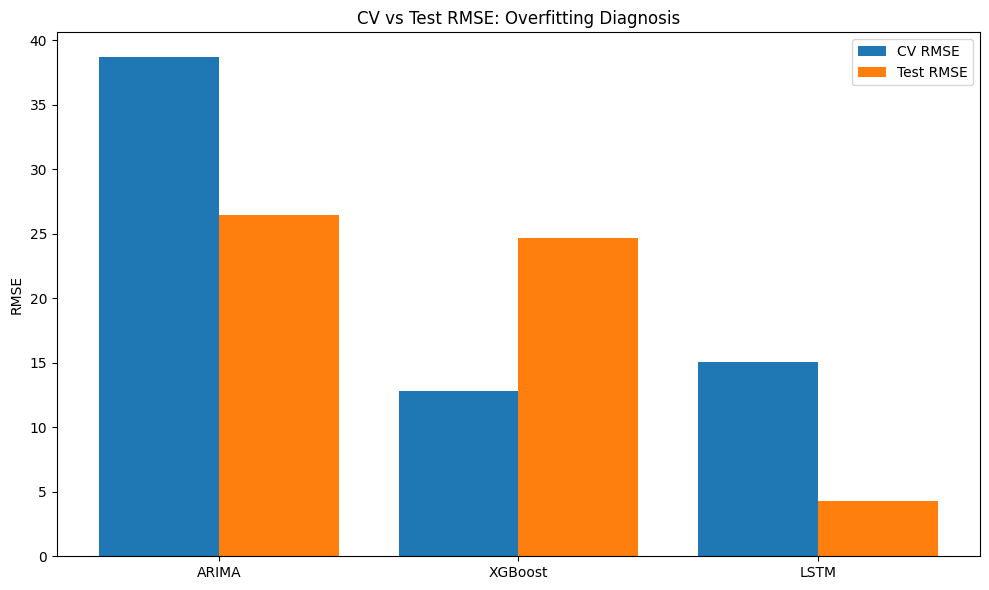

In [79]:
""" visualize overfitting """
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
plt.bar(x - 0.2, overfit_df['CV_RMSE'], width=0.4, label='CV RMSE')
plt.bar(x + 0.2, overfit_df['Test_RMSE'], width=0.4, label='Test RMSE')
plt.xticks(x, models)
plt.ylabel('RMSE')
plt.title('CV vs Test RMSE: Overfitting Diagnosis')
plt.legend()
plt.tight_layout()
plt.show()